# *Model:* GARCH
# *Stock Data:* NSEI
# *Name: *Abbas Amjherawala**

In [1]:
#install arch module
!pip install arch

#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, acf, pacf
from arch import arch_model
from datetime import datetime, timedelta, timezone
from time import time
import warnings

#ignore warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 903.7/903.7 kB 24.1 MB/s eta 0:00:0000:01


In [2]:
#retrieve data from stock csv and split into test and train
_df = pd.read_csv('/kaggle/input/nsei-prev-data/in_nsei_daily.csv', index_col='minute', parse_dates=True)
_df = _df.interpolate()
train_data = _df[:'2020-12-31']
test_data = _df['2021-01-01':]
print(train_data)
print(test_data)

                          ticker    instrument_token      open      high  \
minute                                                                     
2017-01-02 09:15:00+05:30   NSEI  uf-n-1647516806122   8211.70   8211.70   
2017-01-03 09:15:00+05:30   NSEI  uf-n-1647516806122   8195.25   8219.00   
2017-01-04 09:15:00+05:30   NSEI  uf-n-1647516806122   8201.60   8218.45   
2017-01-05 09:15:00+05:30   NSEI  uf-n-1647516806122   8227.75   8282.55   
2017-01-06 09:15:00+05:30   NSEI  uf-n-1647516806122   8283.50   8306.50   
...                          ...                 ...       ...       ...   
2020-12-24 09:15:00+05:30   NSEI  uf-n-1647516806122  13643.95  13771.75   
2020-12-28 09:15:00+05:30   NSEI  uf-n-1647516806122  13824.40  13885.30   
2020-12-29 09:15:00+05:30   NSEI  uf-n-1647516806122  13915.50  13967.60   
2020-12-30 09:15:00+05:30   NSEI  uf-n-1647516806122  13982.90  13997.00   
2020-12-31 09:15:00+05:30   NSEI  uf-n-1647516806122  13978.25  14024.85   

           

In [3]:
prices = train_data['close']
prices

minute
2017-01-02 09:15:00+05:30     8178.70
2017-01-03 09:15:00+05:30     8188.60
2017-01-04 09:15:00+05:30     8196.55
2017-01-05 09:15:00+05:30     8269.90
2017-01-06 09:15:00+05:30     8247.85
                               ...   
2020-12-24 09:15:00+05:30    13740.40
2020-12-28 09:15:00+05:30    13883.25
2020-12-29 09:15:00+05:30    13928.10
2020-12-30 09:15:00+05:30    13973.65
2020-12-31 09:15:00+05:30    13967.20
Name: close, Length: 987, dtype: float64

In [4]:
returns = prices.pct_change().dropna()
returns

minute
2017-01-03 09:15:00+05:30    0.001210
2017-01-04 09:15:00+05:30    0.000971
2017-01-05 09:15:00+05:30    0.008949
2017-01-06 09:15:00+05:30   -0.002666
2017-01-09 09:15:00+05:30   -0.001540
                               ...   
2020-12-24 09:15:00+05:30    0.009570
2020-12-28 09:15:00+05:30    0.010396
2020-12-29 09:15:00+05:30    0.003231
2020-12-30 09:15:00+05:30    0.003270
2020-12-31 09:15:00+05:30   -0.000462
Name: close, Length: 986, dtype: float64

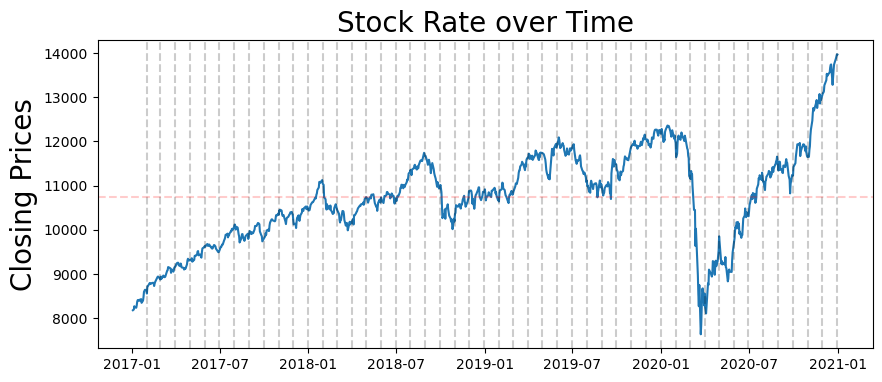

In [5]:
#plot graphs, acf and pacf to determine ar and ma
plt.figure(figsize=(10,4))
plt.plot(prices)
plt.ylabel('Closing Prices', fontsize=20)
plt.title('Stock Rate over Time', fontsize=20)

dates = pd.date_range(start='2017-01-03', end='2020-12-31', freq='M')
for date in dates:
    plt.axvline(date, color='k', linestyle='--', alpha=0.2)
plt.axhline(prices.mean(), color='r', alpha=0.2, linestyle='--')

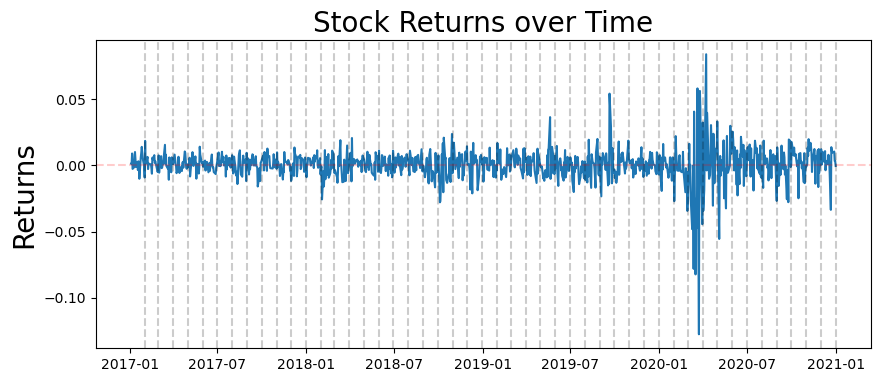

In [6]:
plt.figure(figsize=(10,4))
plt.plot(returns)
plt.ylabel('Returns', fontsize=20)
plt.title('Stock Returns over Time', fontsize=20)

dates = pd.date_range(start='2017-01-03', end='2020-12-31', freq='M')
for date in dates:
    plt.axvline(date, color='k', linestyle='--', alpha=0.2)
plt.axhline(returns.mean(), color='r', alpha=0.2, linestyle='--')

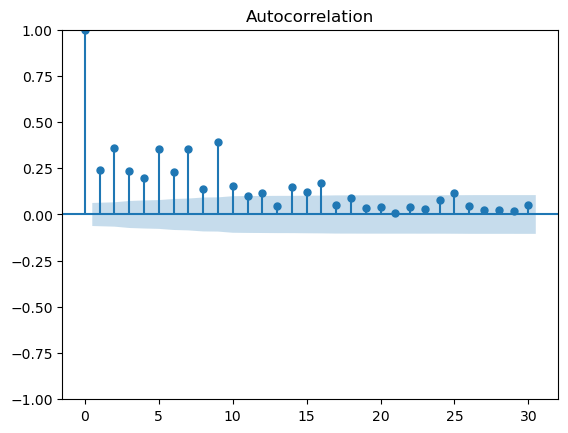

In [7]:
plot_acf(returns**2)
plt.show()

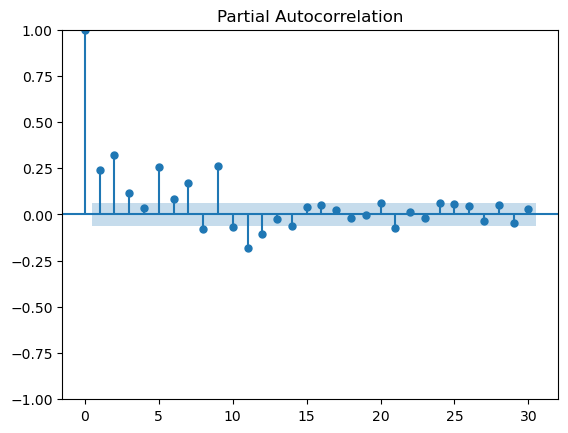

In [8]:
plot_pacf(returns**2, method='ywm')
plt.show()

In [9]:
#predict data using model and input manual order (2,7)
import pytz
data_=[]
index_ = test_data.index.tolist()
index_.insert(0, pd.Timestamp('2020-12-31 09:15:00+05:30', tz=pytz.FixedOffset(330)))

try:
    for i in range(1,len(index_)):
        
        returns = train_data['close'].pct_change().dropna()
        model = arch_model(returns, p=2, q=7)
        results = model.fit()
        forecast_horizon = 1
        forecasts = results.forecast(horizon=forecast_horizon)
        predicted_volatility = np.sqrt(forecasts.variance.iloc[-1])
        last_price = train_data[index_[i-1].strftime('%Y-%m-%d')].close[0]
        predicted_price = last_price * np.exp(predicted_volatility * np.random.normal())
        
        train_data.loc[index_[i]] = test_data.loc[index_[i]]            
        if predicted_price[0]<train_data[index_[i-1].strftime('%Y-%m-%d')].close[0]:
            direction='SELL'
            data_.append({'Date': index_[i-1].strftime('%Y-%m-%d'),'Day': index_[i-1].strftime('%A'), 'Current Close Price': train_data[index_[i-1].strftime('%Y-%m-%d')].close[0],'Next Day Price': train_data[index_[i].strftime('%Y-%m-%d')].close[0],'Predicted Direction' : direction,'Predicted Value': predicted_price[0], 'Pnl':train_data[index_[i-1].strftime('%Y-%m-%d')].close[0]-train_data[index_[i].strftime('%Y-%m-%d')].close[0]})
        else:
            direction='BUY'
            data_.append({'Date': index_[i-1].strftime('%Y-%m-%d'),'Day': index_[i-1].strftime('%A'), 'Current Close Price': train_data[index_[i-1].strftime('%Y-%m-%d')].close[0],'Next Day Price': train_data[index_[i].strftime('%Y-%m-%d')].close[0],'Predicted Direction' : direction,'Predicted Value': predicted_price[0], 'Pnl':train_data[index_[i].strftime('%Y-%m-%d')].close[0]-train_data[index_[i-1].strftime('%Y-%m-%d')].close[0]})

    
except KeyboardInterrupt or ValueError:
    print("Output is Stored in csv file: NSEI_STOCK.CSV!")

Iteration:      1,   Func. Count:     13,   Neg. LLF: 5845403123.473472
Iteration:      2,   Func. Count:     32,   Neg. LLF: 3522240174.193923
Iteration:      3,   Func. Count:     51,   Neg. LLF: 49354415.05813289
Iteration:      4,   Func. Count:     69,   Neg. LLF: -3266.050969733492
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3266.050972420272
            Iterations: 8
            Function evaluations: 69
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: 1.5239530685866747e+20
Iteration:      2,   Func. Count:     32,   Neg. LLF: 3464943042.9060464
Iteration:      3,   Func. Count:     51,   Neg. LLF: 1623423647.785842
Iteration:      4,   Func. Count:     70,   Neg. LLF: 752883436.5246431
Iteration:      5,   Func. Count:     89,   Neg. LLF: 3217923.9020091253
Iteration:      6,   Func. Count:    107,   Neg. LLF: 129677678.32393771
Iteration:      7,   Func. Count:    126,   Neg. LLF: 70809279.

In [10]:
#append data to a list and store in csv
import csv
import os

headers = ['Date', 'Day', 'Current Close Price', 'Next Day Price','Predicted Direction', 'Predicted Value','Pnl']

if os.path.exists('/kaggle/working/nsei_stock.csv'):
    with open('nsei_stock.csv', mode='a', newline='') as csv_file:
        writer = csv.DictWriter(csv_file, fieldnames=headers)
        for row in data_:
            writer.writerow(row)
else:
    with open('nsei_stock.csv', mode='w', newline='') as csv_file:
        writer = csv.DictWriter(csv_file, fieldnames=headers)
        writer.writeheader()
        for row in data_:
            writer.writerow(row)


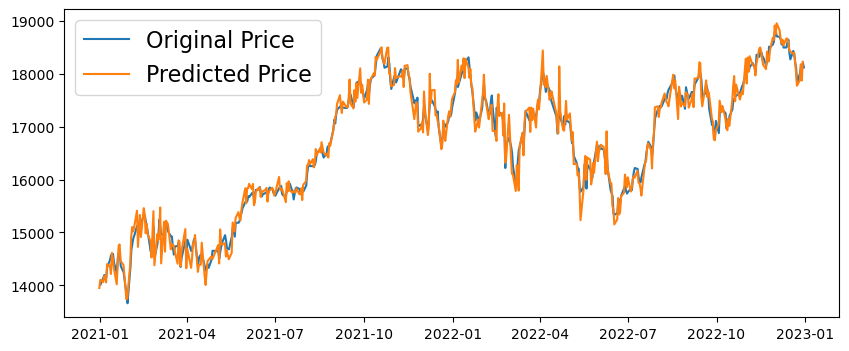

In [11]:
#plot graph between original and predicted
_df = pd.read_csv('/kaggle/working/nsei_stock.csv', index_col='Date', parse_dates=True)
plt.figure(figsize=(10,4))

plt.plot(test_data.close)
plt.plot(_df['Predicted Value'])
plt.legend(('Original Price', 'Predicted Price'), fontsize=16)